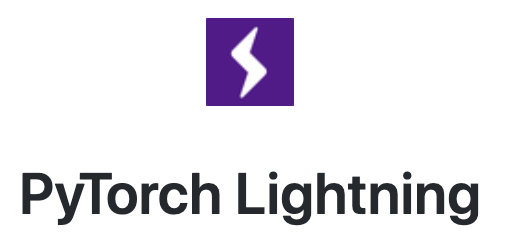

# Lit ALBERT tutorial
This notebook is a part of the Question Answering project and is devoted to the preprocessing step. We preprocess the SQUAD 2.0 dataset with ALBERT tokenizer and pickle the result, which is used in the next notebook for training the model.

## Setup  


Install the transformers library from Huggingface

In [ ]:
%tensorflow_version 1.x
! pip install transformers

TensorFlow 1.x selected.
     |████████████████████████████████| 1.3MB 12.9MB/s 
     |████████████████████████████████| 2.9MB 50.0MB/s 
     |████████████████████████████████| 1.1MB 17.4MB/s 
     |████████████████████████████████| 890kB 47.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=9fd0b46b7e0d7407bf955d91ffcbc8ee5eb2eaeb939d3fe5015c9b6998952356
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


## Data download + processing

Mount your Google Drive to get access to the dataset file

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir_read = root_dir + 'ybshmmlchk/zatoboj/SQUAD/'
base_dir_write = root_dir + 'ybshmmlchk/'

Mounted at /content/gdrive


Importing necessary libraries and Albert Tokenizer from the transformers library

In [ ]:
import tensorflow as tf
import json
from transformers import (
    AlbertTokenizer
)

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v1')

BERT/Albert tokenizer doesn't just assign tokens to words -- it first breaks (some) words into pieces, and assigns tokens to each of those. In case of BERT WordPiece is used for that (see BERT paper), for Albert -- not sure. Here is an example: "superposition" is not in vocabulary and it gets split into 2 pieces.

In [ ]:
# split into tokens
a = tokenizer.tokenize('Quantum superposition is a fundamental principle of quantum mechanics.')
print(a)
# get the ids of corresponding tokens
b = tokenizer.convert_tokens_to_ids(a)
print(b)


['▁quantum', '▁super', 'position', '▁is', '▁a', '▁fundamental', '▁principle', '▁of', '▁quantum', '▁mechanics', '.']
[8511, 1026, 9339, 25, 21, 6377, 5897, 16, 8511, 9701, 9]


#### Loading the dataset


In [ ]:
input_file = 'train-v2.0.json'
with open(base_dir_read + input_file, "r") as reader:
    input_data = json.load(reader)["data"]

Example of a paragraph of text with different questions to this paragraph and corresponding answers. 'context' - paragraph. 'qas' -- list of questions. 'is_impossible' -- false if answer is in the text

In [ ]:
from pprint import pprint
pprint(input_data[30]['paragraphs'][6])

{'context': 'The Roman Empire came to dominate the entire Mediterranean basin '
            'in a vast empire based on Roman law and Roman legions. It '
            'promoted trade, tolerance, and Greek culture. By 300 AD the Roman '
            'Empire was divided into the Western Roman Empire based in Rome, '
            'and the Eastern Roman Empire based in Constantinople. The attacks '
            'of the Germanic peoples of northern Europe led to the Fall of the '
            'Western Roman Empire in AD 476, a date which traditionally marks '
            'the end of the classical period and the start of the Middle Ages.',
 'qas': [{'answers': [{'answer_start': 247, 'text': 'Rome'}],
          'id': '56de37c0cffd8e1900b4b684',
          'is_impossible': False,
          'question': 'Where was the headquarters of the Western Roman '
                      'Empire?'},
         {'answers': [{'answer_start': 291, 'text': 'Constantinople'}],
          'id': '56de37c0cffd8e1900b4b685',
 

Unraveling the json structure, so that the result -- preprocessed_data -- will be a list of (question, paragraph, label, answer_start, answer_end, answer_text), which will be one example in our training data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


input_data_train, input_data_val = train_test_split(input_data, 
                                                     test_size=0.05, 
                                                     random_state=420)

len(input_data_train), len(input_data_val)

(419, 23)

In [ ]:
def preprocess_organize(input_data: list) -> list:
  """Организуем данные"""
  preprocessed_data = list()
  for entry in input_data:
    for paragraph in entry["paragraphs"]:
      paragraph_text = paragraph["context"]
      for qa in paragraph["qas"]:
        question_text = qa['question']
        label = qa["is_impossible"]
        if not label:
          answer_start = qa["answers"][0]["answer_start"]
          answer_text = qa["answers"][0]["text"]
        else:
          answer_start = qa["plausible_answers"][0]["answer_start"]
          answer_text = qa["plausible_answers"][0]["text"]
        answer_end = answer_start + len(answer_text)
        preprocessed_data.append([question_text, paragraph_text, label, answer_start, answer_end, answer_text])
  preprocessed_data = shuffle(preprocessed_data, random_state=420)
  return preprocessed_data


preprocessed_data_train = preprocess_organize(input_data_train)
preprocessed_data_val = preprocess_organize(input_data_val)

In [ ]:
print(len(preprocessed_data_train), len(preprocessed_data_val))

124368 5951


Now we tokenize all the pairs (question, paragaraph). We combine the question and paragraph together. If the length of the tokenized result is bigger than MAX_LEN (=256), the pair is discarded.

In [ ]:
from tqdm import tqdm_notebook

def preprocess_tokenize(preprocessed_data: list) -> dict:
  input_ids, token_type_ids, labels = [], [], [] 
  attention_mask, answer_mask, plausible_answer_mask = [], [], []
  full_questions, actual_answers, full_paragraphs, plausible_answers = [], [], [], []
  answer_starts, answer_ends = [], []
  MAX_LEN = 256

  for step in tqdm_notebook(preprocessed_data):
    question, paragraph, label, answer_start, answer_end, answer_text = step

    #tokenizing the question and the paragraph
    tmp_question = tokenizer.tokenize(question)

    #tokenizing the paragraph. tokenizing the part before the answer, the answer, and after the answer separately to keep track of tokens corresponding to the answer
    tmp_preanswer = tokenizer.tokenize(paragraph[0:answer_start])
    tmp_answer = tokenizer.tokenize(paragraph[answer_start:answer_end])
    tmp_postanswer = tokenizer.tokenize(paragraph[answer_end:])
    tmp_paragraph = tmp_preanswer + tmp_answer + tmp_postanswer

    len_q, len_p = len(tmp_question), len(tmp_paragraph)

    if len_q + len_p + 3 <= MAX_LEN:
      input_ids.append(tokenizer.convert_tokens_to_ids(["[CLS]"] + tmp_question + ["[SEP]"] + tmp_paragraph + ["[SEP]"]) + [0]*(MAX_LEN - (len_q + len_p + 3)))
      token_type_ids.append([0 for i in range(len_q + 2)] + [1 for i in range(MAX_LEN - (len_q + 2))]) 
      attention_mask.append([1 for i in range(len_q + len_p + 3)] + [0 for i in range(len_q + len_p + 3, MAX_LEN)])    
      answer_start = len_q + len(tmp_preanswer) + 2 
      answer_end = len_q + len(tmp_preanswer) + len(tmp_answer) + 2
      plausible_answer_mask.append([0 for i in range(answer_start)] + [1 for i in range(answer_start, answer_end)] + [0 for i in range(answer_end, MAX_LEN)])
      if label:
        answer_mask.append([0 for i in range(MAX_LEN)])
        answer_starts.append(0)
        answer_ends.append(0)
        actual_answers.append('no answer')
        plausible_answers.append(answer_text)
      else:
        answer_mask.append([0 for i in range(answer_start)] + [1 for i in range(answer_start, answer_end)] + [0 for i in range(answer_end, MAX_LEN)])
        answer_starts.append(answer_start)
        answer_ends.append(answer_end-1)
        plausible_answers.append('no answer')
        actual_answers.append(answer_text)
      labels.append(label)
      full_questions.append(question)
      full_paragraphs.append(paragraph)
      
  
  dict_data = {
    "input_ids": input_ids, 
    "token_type_ids": token_type_ids, 
    "labels": labels, 
    "attention_mask": attention_mask, 
    'answer_mask' : answer_mask, 
    'plausible_answer_mask' : plausible_answer_mask,
    'actual_answers' : actual_answers,
    'full_questions' : full_questions,
    'full_paragraphs' : full_paragraphs,
    'plausible_answers' : plausible_answers,
    'answer_starts' : answer_starts,
    'answer_ends' : answer_ends
    }
  return dict_data

dict_data_train = preprocess_tokenize(preprocessed_data_train)
dict_data_val = preprocess_tokenize(preprocessed_data_val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


Finally, we organize all the training data + additional data in a dictionary, and then pickle it. Note that the number of training examples dropped by about 14K due to discarding of long paragraph-question pairs.

In [ ]:
import pickle

pickle.dump(dict_data_train, open(base_dir_write + "albert_base_256_train.pickle", "wb"))
pickle.dump(dict_data_val, open(base_dir_write + "albert_base_256_val.pickle", "wb"))

print(len(dict_data_train["labels"]), len(dict_data_val["labels"]))

111281 5296


## TEST
Just a few functions for extraction of answers



In [ ]:
import numpy
def get_ans(i):
  return get_answer(input_ids[i], answer_mask[i])

def get_plaus_ans(i):
  return get_answer(input_ids[i], plausible_answer_mask[i])

def get_answer(input_id, answer):
  indices = (numpy.nonzero(answer)[0]).tolist()
  #  indices.append(l[0])
  if indices:
    tokens = tokenizer.convert_ids_to_tokens(input_id)
    return tokens[indices[0]:indices[-1]+1]
  else:
    return None

In [ ]:
# from random import randint
# i = randint(0, len(dict_data['labels']))
# print(get_ans(i), full_answers[i])
# print(get_plaus_ans(i), full_answers[i])

['▁australian', '▁federal', '▁taxes'] Australian federal taxes
['▁australian', '▁federal', '▁taxes'] Australian federal taxes


In [ ]:
# print(i)

89152


In [1]:
#test